# Его величество, "домашка №1"

В этой домашней работе вам предоставится уникальная возможность обучить Byte-level BPE токенизатор и небольшую LM.  

Домашняя работа состоит из нескольких последовательных блоков: реализация и обучение токенизатора, реализация Transformer модели и обучение модели на датасете с русскими анекдотами!

Обученные токенизатор и модель можно и нужно выложить на [🤗 HuggingFace](https://huggingface.co/). Зарегистрируйтесь там, подпишитесь на [deep vk](https://huggingface.co/deepvk) и создайте себе API токен.

Следуйте ячейкам тетрадки и заполняйте пропущенные ячейки. В конце тетрадки вы найдете задачи со звездочкой, чтобы получить максимальный балл!

In [3]:
# Установим необходимые дополнительные библиотеки

%pip install --quiet datasets livelossplot

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Необходимые импорты

import inspect
import json
import os
from collections import Counter
from dataclasses import dataclass
from functools import lru_cache, partial
from pathlib import Path

import regex as re
import torch
import torch.nn as nn
from datasets import load_dataset
from huggingface_hub import HfApi, PyTorchModelHubMixin, interpreter_login, snapshot_download
from huggingface_hub.utils import SoftTemporaryDirectory
from livelossplot import PlotLosses
from torch import Tensor
from torch.nn import functional as F
from torch.utils.data import DataLoader
from tqdm.auto import tqdm, trange

In [3]:
# Этой функцией будут помечены все места, которые необходимо дозаполнить
# Это могут быть как целые функции, так и отдельные части внутри них
# Всегда можно воспользоваться интроспекцией и найти места использования этой функции :)


def todo():
    stack = inspect.stack()
    caller_frame = stack[1]
    function_name = caller_frame.function
    line_number = caller_frame.lineno
    raise NotImplementedError(f"TODO at {function_name}, line {line_number}")

In [4]:
interpreter_login()


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|



Enter your token (input will not be visible):  ········
Add token as git credential? (Y/n)  n


In [5]:
# Подготовим репозиторий для будущей модели и токенизатора
username = HfApi().whoami()["name"]
REPO_NAME = 'andreykaa03/llm-course-hw1'  # Или как вам хочется

print(f"Homework repository: '{REPO_NAME}'")

# И другие полезные вещи
SEED = 0xC0FFEE

Homework repository: 'andreykaa03/llm-course-hw1'


# Датасет

Первым делом загрузим данные: [🤗 IgorVolochay/russian_jokes](https://huggingface.co/datasets/IgorVolochay/russian_jokes)

И немного посмотрим на них 👀

In [5]:
dataset = load_dataset("IgorVolochay/russian_jokes", data_files="dataset.csv")
print("\n===\n".join(dataset["train"]["text"][:3]))

- Зять, а ты знаешь, где найти того мужчину, который спас меня, когда я тонула?- Да, он уже приходил ко мне извиняться!  
===
После проведения акции "К животным по-человечески" животные посовещались  и решили провести акцию "К человеку по-скотски".  
===
Штирлиц пришел домой и сразу завалился на боковую. Средняя от досады заплакала.  


In [6]:
# Подготовим холдауты
dataset = dataset["train"].train_test_split(test_size=0.1, seed=SEED)
dataset['train']

Dataset({
    features: ['text'],
    num_rows: 135497
})

# Токенизатор [6 баллов]

В качестве токенизатора будем использоват Byte-level BPE.

Для этого:
1. Реализуем его обучения, нам необходимо построить словарь заданного размера и набор слияний по этому словарю
2. Обучим токенизатор на датасете
3. Реализуем инференс токенизатора: кодирование текста и декодирование токенов


In [6]:
# Всякие полезности

WHITESPACE_SPLITTER = re.compile(r"""'s|'t|'re|'ve|'m|'ll|'d| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+""")


def bytes_to_unicode() -> dict[int, str]:
    """The original dictionary consists of 256 bytes and their corresponding Unicode characters.
    For example, chr(33) is '!'. However, not all bytes have a visually appealing representation,
    so such characters are skipped and replaced with the first available ones, i.e. shifted by 256.
    """
    initial_bytes = (
        list(range(ord("!"), ord("~") + 1)) + list(range(ord("¡"), ord("¬") + 1)) + list(range(ord("®"), ord("ÿ") + 1))
    )
    initial_chars = [chr(it) for it in initial_bytes]
    n = 0
    for byte in range(2**8):
        if byte not in initial_bytes:
            initial_bytes.append(byte)
            initial_chars.append(chr(2**8 + n))
            n += 1
    return dict(sorted(zip(initial_bytes, initial_chars)))

In [7]:
WHITESPACE_SPLITTER.findall(dataset["train"]["text"][0].strip())

NameError: name 'dataset' is not defined

In [9]:
def merge(merge_pair: tuple[str, str], pair_frequences: Counter[tuple[str, str]], words_by_tokens: Counter[tuple[str]]):
    """Merges a given pair of tokens and update corresponding stats

    Args:
        merge_pair: The pair of tokens to be merged.
        pair_frequences: A counter tracking the frequency of token pairs in the dataset.
        words_by_tokens: A counter mapping tokenized words to their frequencies.

    Returns:
        Updated pair frequences and word tokenization w.r.t. to new token.
    """
    new_pair_frequences, new_words_by_tokens = Counter(), Counter()
    new_token = ''.join(merge_pair)

    for word, frequence in words_by_tokens.items():
        new_tokenized_word = tuple()
        flag = False

        for token in word:
            if token == merge_pair[0]:
                if flag:
                    new_tokenized_word += tuple([merge_pair[0]])
                flag = True
            elif token == merge_pair[1]:
                if flag:
                    new_tokenized_word += tuple([new_token])
                    flag = False
                else:
                    new_tokenized_word += tuple([token])
            else:
                if flag:
                    new_tokenized_word += tuple([merge_pair[0]])
                flag = False
                new_tokenized_word += tuple([token])

        new_words_by_tokens.setdefault(new_tokenized_word, 0)
        new_words_by_tokens[new_tokenized_word] += frequence

    for word, frequence in new_words_by_tokens.items():
        for i in range(len(word)):
            if not i:
                continue

            new_pair_frequences.setdefault(tuple([word[i-1], word[i]]), 0)
            new_pair_frequences[tuple([word[i-1], word[i]])] += frequence

    return [new_pair_frequences, new_words_by_tokens]


def train(data: list[str], vocab_size: int = 1024, special_tokens: list[str] = None):
    """Train BPE tokenizer on passed data

    Args:
        data: List of train documents
        vocab_size: Size of target vocabulary
        special_tokens: List of special tokens to add into vocabulary
    Returns:
        vocabulary: mapping from string token to id
        merges: list of merges, each one is tuple of string tokens
    """
    if vocab_size < 256:
        raise ValueError("Vocab size can't be less than 256")
    if special_tokens is None:
        special_tokens = []

    # 1. Initialize vocabulary (using inverse one during training)
    id2token = bytes_to_unicode()
    merges = []

    # 2. Load data
    words_by_tokens = Counter()
    for sample in tqdm(data, desc="Loading data"):
        # 2.1 Split into words
        words = WHITESPACE_SPLITTER.findall(sample.strip())
        for word in words:
            # 2.2 Tokenize with base vocabulary
            words_by_tokens.setdefault(tuple(word), 0)
            words_by_tokens[tuple(word)] += 1

    # 3. Calculate statistic of token's pairs
    pair_frequences = Counter()
    for word, frequence in words_by_tokens.items():
        for i in range(len(word)):
            if word[i] not in id2token.values():
                id2token[len(id2token)] = word[i]

            if not i:
                continue

            pair_frequences.setdefault(tuple([word[i-1], word[i]]), 0)
            pair_frequences[tuple([word[i-1], word[i]])] += frequence

    # 4. Build vocabulary
    pbar = trange(vocab_size, desc="Building vocabulary", initial=len(id2token) + len(special_tokens))
    while len(id2token) < vocab_size - len(special_tokens):
        if len(pair_frequences) == 0:
            print("Not enough data to fulfil vocabulary")
            break

        # 4.1 Find the most frequent pair and create new token
        top_pair = pair_frequences.most_common(1)[0][0]
        new_token = ''.join(top_pair)
        del pair_frequences[top_pair]

        # 4.2 Add to vocabulary
        if new_token in id2token.values():
            continue
        id2token[len(id2token)] = new_token
        merges.append(top_pair)

        # 4.3 Update stats and merge the top pair in all tokens
        pair_frequences, words_by_tokens = merge(top_pair, pair_frequences, words_by_tokens)

        pbar.update()
    pbar.close()

    # 5. Add special tokens
    for special_token in special_tokens:
        id2token[len(id2token)] = special_token

    return {v: k for k, v in id2token.items()}, merges

In [ ]:
# Обучаем токенизатор на тренировочных текстах
# Для нашей задачи хватит и небольшого словаря, но можете пробовать и большего размера обучить!


vocab, merges = train(dataset["train"]["text"], vocab_size=1024, special_tokens=["[EOS]"])

In [ ]:
import pickle

with open("vocab_marges.bin", "wb") as fd:
    pickle.dump([vocab, merges], fd)

In [ ]:
import pickle

with open("vocab_marges.bin", "rb") as fd:
    vocab, merges = pickle.load(fd)

In [ ]:
# Посмотрим на случайные токены

random_tokens = [512, 614, 768, 888, 1022]
unicode_to_bytes = {v: k for k, v in bytes_to_unicode().items()}
for i in range(ord('а'), ord('я')+1):
    unicode_to_bytes[chr(i)] = i
for i in range(ord('А'), ord('Я')+1):
    unicode_to_bytes[chr(i)] = i

In [ ]:
for token_id in random_tokens:
    token = [k for k, v in vocab.items() if v == token_id][0]
    print(token)
    #raw_bytes = bytes([unicode_to_bytes[it] for it in token])
    #print(f"Token #{token_id}: '{raw_bytes.decode('utf-8', errors='replace')}'")

In [8]:
class ByteLevelBPETokenizer:

    def __init__(self, vocab: dict[str, int], merges: list[tuple[str, str]], eos_token: str = "[EOS]"):
        """Byte-Level BPE Tokenizer

        Args:
            vocab: mapping from string token to id
            merges: list of merges in prioritized order
            eos_token: string representation of EOS token
        """
        super().__init__()
        if eos_token not in vocab:
            raise ValueError("There is no EOS token in vocab")
        self.byte_encoder = bytes_to_unicode()
        self.byte_decoder = {v: k for k, v in self.byte_encoder.items()}
        self.token2id = vocab
        self.id2token = {v: k for k, v in self.token2id.items()}
        self.eos_token = eos_token
        self.eos_token_id = self.token2id[eos_token]

        # The closer the pair is to the beginning, the higher the rank
        self.merges = merges
        self.bpe_ranks = {pair: i for i, pair in enumerate(merges)}

    @lru_cache
    def bpe(self, word: tuple[str]) -> tuple[str]:
        """Process word into tokenized representation.
        Word is a tuple of base tokens, i.e. bytes.

        Under the hood:
        1. Tracks the set of token pairs, bi-grams
        2. While possible, replaces the highest-ranking pair with its union

        Args:
            word: list of base string tokens
        Return:
            list of BPE tokens
        """
        word_cur = word
        while True:
            max_rank = 0
            idx_max_rank = -1
            for i in range(len(word_cur)-1):
                if max_rank < self.token2id.get(word_cur[i]+word_cur[i+1], 0):
                    max_rank = self.token2id.get(word_cur[i]+word_cur[i+1], 0)
                    idx_max_rank = i

            if max_rank:
                word_cur = word_cur[:idx_max_rank] + tuple([self.id2token.get(max_rank, ' ')]) + word_cur[idx_max_rank+2:]
            else:
                break

        return word_cur

    def encode(self, text: str, add_eos_token: bool = True) -> list[int]:
        """Convert string to list of token ids.

        Args:
            text: input string, may contain multiple words
            add_eos_token: whether to add eos token id at the end
        Return:
            list of ints, ids of tokenized text
        """
        words = WHITESPACE_SPLITTER.findall(text)
        ids_tokenized = list()
        for word in words:
            for bpe_token in self.bpe(tuple(word)):
                ids_tokenized.append(self.token2id.get(bpe_token, self.token2id[' ']))

        if add_eos_token:
            ids_tokenized.append(self.eos_token_id)

        return ids_tokenized

    def decode(self, idx: list[int]) -> str:
        """Convert list of tokens' ids to text, opposite to encode method

        Args:
            idx: list of tokens' ids
        Return:
            string, decoded text
        """
        str_token = ""
        for ids in idx:
            str_token += self.id2token[ids]

        return str_token

    def push_to_hub(self, repo_id, *, private=None, token=None):
        api = HfApi()
        repo_id = api.create_repo(repo_id=repo_id, token=token, private=private, exist_ok=True).repo_id

        # Push the files to the repo in a single commit
        with SoftTemporaryDirectory() as tmp:
            save_directory = Path(tmp) / repo_id
            save_directory.mkdir(parents=True)
            with open(save_directory / "vocabulary.json", "w") as f_out:
                print(json.dumps(self.token2id, indent=2), file=f_out)
            with open(save_directory / "merges.json", "w") as f_out:
                print(json.dumps({"merges": self.merges}), file=f_out)

            return api.upload_folder(repo_id=repo_id, folder_path=save_directory, token=token)

    @classmethod
    def from_pretrained(cls, pretrained_model_name_or_path, *, token=None, **model_kwargs):
        if not os.path.isdir(pretrained_model_name_or_path):
            storage_folder = snapshot_download(repo_id=pretrained_model_name_or_path, token=token)
        else:
            storage_folder = pretrained_model_name_or_path
        storage_folder = Path(storage_folder)
        with open(storage_folder / "vocabulary.json", "r") as f_in:
            vocab = json.load(f_in)
        with open(storage_folder / "merges.json", "r") as f_in:
            merges = [tuple(it) for it in json.load(f_in)["merges"]]
        return cls(vocab, merges, **model_kwargs)

In [ ]:
# Инициализируем токенизатор


tokenizer = ByteLevelBPETokenizer(vocab, merges)

In [ ]:
# Загружаем токенизатор на хаб

tokenizer.push_to_hub(REPO_NAME)

In [11]:
# Скачиваем токенизатор с хаба

tokenizer = ByteLevelBPETokenizer.from_pretrained(REPO_NAME)

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/162 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/30.1M [00:00<?, ?B/s]

In [12]:
# Смотрим на работу токенизатора

text = "Что было полгода назад? Помимо грандиозных событий, полгода назад были ещё семинары по линейной алгебре."
ids = tokenizer.encode(text)
print(ids)
reverse_text = [tokenizer.decode([it]) for it in ids]
print("|".join(reverse_text))
print(tokenizer.decode(ids))

[310, 622, 716, 648, 628, 276, 633, 658, 637, 647, 270, 63, 754, 695, 689, 734, 623, 258, 660, 263, 288, 664, 289, 712, 782, 676, 297, 44, 628, 276, 633, 658, 637, 647, 270, 716, 635, 771, 295, 315, 862, 695, 651, 729, 628, 830, 894, 297, 776, 671, 276, 269, 257, 286, 644, 46, 1023]
Ч|то| бы|ло| по|л|го|да| на|за|д|?| По|ми|мо| г|ра|н|ди|о|з|ны|х| со|бы|ти|й|,| по|л|го|да| на|за|д| бы|ли| е|щ|ё| се|ми|на|ры| по| ли|не|й|ной| а|л|г|е|б|ре|.|[EOS]
Что было полгода назад? Помимо грандиозных событий, полгода назад были ещё семинары по линейной алгебре.[EOS]


In [2]:
# Посчитаем немного статистики по токенизации, определимся с размером контекста у модели

lens = []
for text in tqdm(dataset["test"]["text"]):
    ids = tokenizer.encode(text)
    lens.append(len(ids))

print(f"Average token len per sample: {sum(lens) / len(lens):.2f}")
print(f"Minimum and maximum lens are: {min(lens)} and {max(lens)}")

NameError: name 'tqdm' is not defined

Должно получиться в среднем по 70 токенов на последовательность.
Контекста в 128 токенов будет вполне достаточно.

# Модель [10 баллов]

В качестве модели реализуем трансформер, в котором
1. В качестве позиционных эмбеддингов используется ALiBi
2. Механизм внимания использует GQA
3. В Feed-Forward блоке SwiGLU

In [9]:
# Для удобства заведем конфиг для модели


@dataclass
class TransformerConfig:
    n_layer: int
    n_head: int
    n_kv_head: int
    hidden_dim: int
    intermediate_dim: int
    dropout: float = 0.1
    vocab_size: int = 1024
    max_seq_len: int = 128


model_configs = {
    "nano": TransformerConfig(n_layer=3, n_head=4, n_kv_head=2, hidden_dim=96, intermediate_dim=256),
    "mini": TransformerConfig(n_layer=6, n_head=6, n_kv_head=3, hidden_dim=384, intermediate_dim=1024),
    "small": TransformerConfig(n_layer=12, n_head=12, n_kv_head=6, hidden_dim=768, intermediate_dim=2048),
    "big": TransformerConfig(n_layer=48, n_head=48, n_kv_head=24, hidden_dim=3072, intermediate_dim=8192)
}

In [10]:
class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        """Root Mean Square Layer Normalization

        Args:
            dim: Feature dimension
            eps: Small constant for numerical stability
        """
        super().__init__()
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(dim))

    def forward(self, x: Tensor) -> Tensor:
        rms = torch.rsqrt(torch.mean(x**2, dim=-1, keepdim=True) + self.eps)
        return self.scale * x * rms


class CausalSelfAttention(nn.Module):
    def __init__(self, config: TransformerConfig):
        """Causal Self-Attention with support of
        Grouped-Query Attention and ALiBi for positional encoding
        """
        super().__init__()
        self.config = config
        assert self.config.hidden_dim % self.config.n_head == 0
        assert self.config.n_head % self.config.n_kv_head == 0
        self.head_dim = self.config.hidden_dim // self.config.n_head
        self.scale = self.head_dim**-0.5
        self.q_per_kv = self.config.n_head // self.config.n_kv_head

        # Init projection layers
        self.q_proj = nn.Linear(self.config.hidden_dim, self.config.hidden_dim, bias=False)

        self.kv_proj = nn.Linear(self.config.hidden_dim, 2 * self.config.n_kv_head * self.head_dim, bias=False)

        self.out_proj = nn.Linear(self.config.hidden_dim, self.config.hidden_dim, bias=False)

        self.attn_dropout = nn.Dropout(config.dropout)

        self.register_buffer("causal_mask", self._create_causal_mask(self.config.max_seq_len))

        self.alibi = self._build_alibi_bias(config.n_head)

        self.register_buffer("ALiBi", self.alibi * self._create_distance_matrix(config.max_seq_len))

    def _build_alibi_bias(self, num_heads: int) -> Tensor:
        """Build ALiBi for specified number of heads:

        Returns:
            Tensor with ALiBi biases, shape: [num heads, 1, 1, 1]
        """
        alibi_bias = torch.pow(2, torch.arange(-8/num_heads, -8 - 8/num_heads, -8/num_heads))

        return alibi_bias.view([num_heads, 1, 1, 1])

    def _create_causal_mask(self, max_seq_len: int) -> Tensor:
        """Create causal mask with ones where tokens can attend to each other.

        Returns:
            Tensor with causal mask, shape: [1, 1, seq len, seq len]
        """
        causal_mask = torch.tril(torch.ones([max_seq_len, max_seq_len], dtype=torch.bool))

        return causal_mask.view([1, 1, max_seq_len, max_seq_len])

    def _create_distance_matrix(self, max_seq_len: int) -> Tensor:
        dist_matrix = torch.arange(max_seq_len).view(1, 1, 1, -1) - \
                      torch.arange(max_seq_len).view(1, 1, -1, 1)

        return dist_matrix.masked_fill(self.causal_mask == False, 0)

    def forward(self, x: Tensor, attention_mask: Tensor = None) -> Tensor:
        """Apply Self-Attention to input data with respect to pad tokens.

        Args:
            x: input tensor, shape [bs, seq len, hidden dim]
            attention_mask: mask with zeros for pad tokens, shape [bs, seq len, hidden dim]
        Returns:
            result tensor, shape [bs, seq len, hidden dim]
        """
        bs, seq_len, _ = x.shape

        Q = self.q_proj(x).view(bs, seq_len, self.config.n_head, self.head_dim).permute(2, 0, 1, 3)

        K, V = self.kv_proj(x).view(bs, seq_len, 2 * self.config.n_kv_head, self.head_dim\
                                                      ).permute(2, 0, 1, 3).chunk(2, dim=0)

        attention_logits = torch.cat([(K[int(i // self.q_per_kv)]@torch.transpose(Q[i], 1, 2)).unsqueeze(0) \
                                       for i in range(self.config.n_head)], dim=0)

        attention_logits *= self.scale
        attention_logits += self.ALiBi[:, :, :seq_len, :seq_len]

        if attention_mask is not None:
            attention_logits.masked_fill_(attention_mask == 0, value=-1e9)

        attention_logits.masked_fill_(self.causal_mask[:, :, :seq_len, :seq_len] == False, value=-1e9)

        attention_weights = torch.softmax(attention_logits, dim=-1)
        attention_weights = self.attn_dropout(attention_weights)
        attention_out = torch.cat([(attention_weights[i]@V[int(i // self.q_per_kv)]).unsqueeze(0) \
                                       for i in range(self.config.n_head)], dim=0) #[n_head, bs, seq, head_dim]

        attention_out = attention_out.permute(1, 2, 0, 3).contiguous().view(bs, seq_len, -1)
        res = self.out_proj(self.attn_dropout(attention_out))

        return res


class SwiGLU(nn.Module):
    def __init__(self, config: TransformerConfig):
        """Gated Liner Unit with Swish Activation"""
        super().__init__()
        self.config = config
        # Init up- and down- projection layers
        self.fc1 = nn.Linear(config.hidden_dim, 2*config.intermediate_dim)
        self.fc1_dropout = nn.Dropout(config.dropout)
        self.fc2 = nn.Linear(config.intermediate_dim, config.hidden_dim)

    def forward(self, x: Tensor) -> Tensor:
        """Apply SwiGLU to input data.

        Args:
            x: input tensor, shape [bs, seq len, hidden dim]
        Returns:
            result tensor, shape [bs, seq len, hidden dim]
        """
        g, u = self.fc1(x).chunk(2, dim=-1)
        g = F.silu(self.fc1_dropout(g))
        y = self.fc2(u * g)
        #y = self.fc2(g)
        return y


class Block(nn.Module):
    def __init__(self, config: TransformerConfig):
        """Base Transformer Block
        - Causal Self-Attention and SwiGLU as main elements
        - Pre-normalization via RMSNorm
        - Regularization with dropouts before residuals
        """
        super().__init__()
        self.ln_1 = RMSNorm(config.hidden_dim)
        self.res_dropout_1 = nn.Dropout(config.dropout)
        self.attn = CausalSelfAttention(config)

        self.ln_2 = RMSNorm(config.hidden_dim)
        self.res_dropout_2 = nn.Dropout(config.dropout)
        self.mlp = SwiGLU(config)

    def forward(self, x: Tensor, attention_mask: Tensor = None) -> Tensor:
        """Apply Transformer Block to input data.

        Args:
            x: input tensor, shape [bs, seq len, hidden dim]
            attention_mask: mask with zeros for pad tokens, shape [bs, seq len, hidden dim]
        Returns:
            result tensor, shape [bs, seq len, hidden dim]
        """

        x_norm1 = self.ln_1(x)
        y1 = self.res_dropout_1(self.attn(x_norm1, attention_mask))
        x_norm2 = self.ln_2(x+y1)
        y2 = self.res_dropout_2(self.mlp(x_norm2))
        return x + y1 + y2


class TransformerForCausalLM(nn.Module, PyTorchModelHubMixin):
    def __init__(self, config: TransformerConfig):
        """Transformer model for Language Modeling"""
        super().__init__()
        self.vocab_size = config.vocab_size
        self.max_seq_len = config.max_seq_len
        self.n_layer = config.n_layer
        self.n_head = config.n_head
        self.hidden_dim = config.hidden_dim
        self.dropout = config.dropout
        self.config = config

        self.token_emb = nn.Embedding(config.vocab_size, self.hidden_dim)
        self.emb_dropout = nn.Dropout(config.dropout)
        self.layers = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        self.ln_final = RMSNorm(config.hidden_dim)
        self.lm_head = nn.Linear(config.hidden_dim, config.vocab_size)

        self.apply(self._init_weights)

        n_params = sum(p.numel() for p in self.parameters())
        print(f"Number of parameters: {n_params / 1e6:.2f}M")

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, RMSNorm):
            torch.nn.init.ones_(module.scale)

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor = None) -> Tensor:
        """Calculate logits for given input ids.

        Args:
            x: input tensor, shape [bs, seq len, hidden dim]
            attention_mask: mask with zeros for pad tokens, shape [bs, seq len, hidden dim]
        Returns:
            logits, shape [bs, seq len, hidden dim]
        """
        E = self.emb_dropout(self.token_emb(input_ids))

        if attention_mask is not None:
            attention_mask = attention_mask.view(1, input_ids.shape[0], self.config.max_seq_len, 1)

        for l in self.layers:
            E = l(E, attention_mask)

        y_norm = self.ln_final(E)
        y_head = self.lm_head(y_norm)
        return y_head

    @torch.inference_mode()
    def generate(
        self, idx: Tensor, max_new_tokens, eos_token_id, temperature=1.0, do_sample=False, top_k=None
    ) -> Tensor:
        """Take a conditioning sequence of indices and complete the sequence max_new_tokens times,
        feeding the predictions back into the model each time.

        Args:
            idx: tensor with conditional tokens, shape [seq len]
            max_new_tokens: maximum number of new tokens
            eos_token_id: index of EOS token to stop generation
            temperature, do_sample, top_k: generation parameters
        Return:
            tensor with generated indexes
        """
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.shape[1] <= self.max_seq_len else idx[:, -self.max_seq_len :]
            logits = self(idx_cond)

            # 1. Pluck the logits at the final step and scale by desired temperature
            logits = logits[0, -1] / temperature

            # 2. Optionally crop the logits to only the top k options
            if top_k is not None:
                s_log, ind_log = torch.sort(logits, descending=True)
                mask = logits>=s_log[min(top_k-1, s_log.shape[0]-1)]
                logits.masked_fill_(mask==0, value = -1e9)

            # 3. apply softmax to convert logits to probabilities
            probs = nn.functional.softmax(logits, dim=-1)

            # 4. Either sample from the distribution or take the most likely element
            if do_sample:
                idx_next = torch.multinomial(probs, 1)
            else:
                idx_next = torch.argmax(probs)

            # 5. Append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next.unsqueeze(0)), dim=1)
            if idx_next == eos_token_id:
                break
        return idx

# Train Loop [2 + 2 балла]

Настало время обучать модель.
Небольшую можно пробовать обучать локально, но лучше всего воспользоваться GPU, например, на Google Colab.

За реализацию 2 балла, и еще 2 балла - если модель научилась генерить анекдоты.

Не забудьте проверить, что вы загрузили нужные веса на HF и у проверяющего скачается нужная версия.

In [69]:
# Определим датасет и как заворачивать семплы в батч
# Разные тексты имеют разную длину, поэтому будет падить до самого длина семпла
# Так же заведем дополнительную маску, чтобы механизм внимания не учитывал падинги


class TextDataset(torch.utils.data.Dataset):
    def __init__(self, texts, tokenizer):
        self.texts = texts
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        texts = self.texts[idx]
        tokenized_sequence = self.tokenizer.encode(texts)
        return tokenized_sequence


def data_collator(
    tokenized_sequences: list[list[int]], pad_token_id: int, max_seq_len: int = None
) -> tuple[torch.Tensor, torch.Tensor]:
    batch_size = len(tokenized_sequences)
    max_batch_seq_len = min(max_seq_len, max((len(it) for it in tokenized_sequences)))

    input_ids = torch.full((batch_size, max_batch_seq_len), pad_token_id)
    attention_mask = torch.zeros((batch_size, max_batch_seq_len))

    for i, tok_seq in enumerate(tokenized_sequences):
        cur_len = min(len(tok_seq), max_batch_seq_len)
        input_ids[i, :cur_len] = torch.tensor(tok_seq[:cur_len])
        attention_mask[i, :cur_len] = 1

    return input_ids, attention_mask


def create_dataloader(dataset, pad_token_id, max_seq_len, batch_size, is_train):
    collate_fn = partial(data_collator, pad_token_id=pad_token_id, max_seq_len=max_seq_len)
    return DataLoader(
        dataset, batch_size=batch_size, shuffle=is_train, drop_last=is_train, collate_fn=collate_fn, pin_memory=True
    )


_d = TextDataset(["Привет!", "Как твои дела?", "Осталось совсем немного до конца"], tokenizer)
_dl = create_dataloader(_d, tokenizer.eos_token_id, max_seq_len=16, batch_size=2, is_train=False)

for i, batch in enumerate(_dl):
    print(f"Batch #{i}")
    input_ids, attn_mask = batch
    print(input_ids, attn_mask, sep="\n\n")

Batch #0
tensor([[ 293,  643,  743,  262,   33, 1023, 1023, 1023, 1023, 1023],
        [ 306,  259,  267,  655,  649,  272,  744,  646,   63, 1023]])

tensor([[1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
Batch #1
tensor([[ 308,  724,  276,  887,  266,  712,  273,  974,  271,  761,  271,  810,
          687,  975,  808, 1023]])

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])


In [70]:
import math

In [71]:
def get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps):
    """Scheduler for Optimizer with linear warmup and linear decay to the end of training

    Args:
        optimizer: torch optimizer to control learning rate
        num_warmup_steps: number of warmup steps
        num_training_steps: total number of training steps
    Return:
        torch learning rate scheduler
    """
    assert num_training_steps >= num_warmup_steps
    base_lr = optimizer.param_groups[0]['lr']
    min_lr = 1e-6

    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return (min_lr + (base_lr - min_lr) * current_step / num_warmup_steps) / base_lr
        cosine_decay = 0.5 * (1 + math.cos(math.pi * (current_step - num_warmup_steps) / (num_training_steps - num_warmup_steps)))
        return (base_lr - min_lr) * cosine_decay / base_lr + min_lr / base_lr

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)


def cross_entropy_loss(input_ids: Tensor, attention_mask: Tensor, logits: Tensor) -> Tensor:
    """Calculate Cross-Entropy loss for Language Modeling task
    Under the hood:
    1. Create targtes based on input ids
    2. Masked out tokens corresponded to paddings
    3. Calculate cross entropy loss

    Args:
        input_ids: tensor with input ids, shape [bs, seq len]
        attention_mask: mask with zeros for pad tokens, shape [bs, seq len]
        logits: predicted logits, shape [bs, seq len, vocab size]
    Return:
        cross entropy loss, single-item tensor
    """
    input_ids = input_ids[:, 1:].contiguous().view(-1)
    attention_mask = attention_mask[:, 1:].contiguous().view(-1).to(dtype=torch.float32)
    logits = logits[:, :-1, :].contiguous().view([-1, logits.shape[2]])

    loss = F.cross_entropy(logits, input_ids, reduction='none')

    masked_loss = loss.masked_select(attention_mask.bool())

    return masked_loss.sum() / attention_mask.sum()

In [72]:
# Определим тренера с наиболее важными гиперпараметрами для обучения


class Trainer:

    def __init__(
        self,
        learning_rate=3e-4,
        weight_decay=0.01,
        clip_grad_norm=1.0,
        n_steps=20_000,
        val_every_n_steps=2_000,
        plot_every_n_steps=100,
    ):
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.clip_grad_norm = clip_grad_norm
        self.n_steps = n_steps
        self.val_every_n_steps = val_every_n_steps
        self.plot_every_n_steps = plot_every_n_steps

        if torch.cuda.is_available():
            self.device = "cuda"
        elif torch.backends.mps.is_available():
            self.device = "mps"
        else:
            self.device = "cpu"
        print("running on device", self.device)

    @torch.no_grad()
    def validate(self, model, val_loader):
        model.eval()
        val_loss = 0.0
        for batch in tqdm(val_loader, desc="Validating", leave=False):
            input_ids, attention_mask = batch
            input_ids = input_ids.to(self.device, non_blocking=True)
            attention_mask = attention_mask.to(self.device, non_blocking=True)

            logits = model(input_ids, attention_mask)  # [bs; seq len; vocab size]
            val_loss += cross_entropy_loss(input_ids, attention_mask, logits)
        return val_loss / len(val_loader)

    def run(self, model, train_loader, val_loader):
        model = model.to(self.device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=0.1 * self.n_steps, num_training_steps=self.n_steps
        )

        model.train()

        plotlosses = PlotLosses(figsize=(15, 9), step_names="Step")
        logs = {"lr": 0, "epoch": 0}

        data_iter = iter(train_loader)
        for iter_num in range(self.n_steps):
            try:
                batch = next(data_iter)
            except StopIteration:
                data_iter = iter(train_loader)
                logs["epoch"] += 1
                batch = next(data_iter)

            input_ids, attention_mask = batch
            input_ids = input_ids.to(self.device, non_blocking=True)
            attention_mask = attention_mask.to(self.device, non_blocking=True)

            logits = model(input_ids, attention_mask)  # [bs; seq len; vocab size]
            loss = cross_entropy_loss(input_ids, attention_mask, logits)

            # backprop and update the parameters
            model.zero_grad(set_to_none=True)
            loss.backward()
            if iter_num > 0 and iter_num % 1000 == 0:
                total_norm = 0
                for name, param in model.named_parameters():
                    if param.grad is not None:
                        param_norm = param.grad.norm(2).item()
                        total_norm += param_norm ** 2
                        print(f"{name}: {param_norm:.6f}")

                total_norm = total_norm ** 0.5
                print(f"Total Gradient Norm: {total_norm:.6f}")
            torch.nn.utils.clip_grad_norm_(model.parameters(), self.clip_grad_norm)
            optimizer.step()
            scheduler.step()

            if iter_num > 0 and iter_num % self.val_every_n_steps == 0:
                val_loss = self.validate(model, val_loader)
                plotlosses.update({"val_loss": val_loss.item()}, current_step=iter_num)
                plotlosses.send()
                model.train()

            if iter_num % self.plot_every_n_steps == 0:
                logs["loss"] = loss.item()
                logs["lr"] = scheduler.get_last_lr()[0]
                plotlosses.update(logs, current_step=iter_num)
                plotlosses.send()

        val_loss = self.validate(model, val_loader)
        plotlosses.update({"val_loss": val_loss.item()}, current_step=iter_num)
        plotlosses.send()

In [73]:
# Создаем тренировочный и тестовые даталоадеры


MAX_SEQ_LEN = 128
BATCH_SIZE = 16

train_dataset = TextDataset(dataset["train"]["text"], tokenizer)
train_dataloader = create_dataloader(
    train_dataset, tokenizer.eos_token_id, max_seq_len=MAX_SEQ_LEN, batch_size=BATCH_SIZE, is_train=True
)

test_dataset = TextDataset(dataset["test"]["text"], tokenizer)
test_dataloader = create_dataloader(
    test_dataset, tokenizer.eos_token_id, max_seq_len=MAX_SEQ_LEN, batch_size=BATCH_SIZE, is_train=False
)

In [74]:
# Инициализируем модель

config = model_configs["big"]
model = TransformerForCausalLM(config)


KeyboardInterrupt



In [64]:
# Инициализируем тренера

trainer = Trainer(learning_rate=3e-4, n_steps=10_000, val_every_n_steps=1_000)

running on device mps


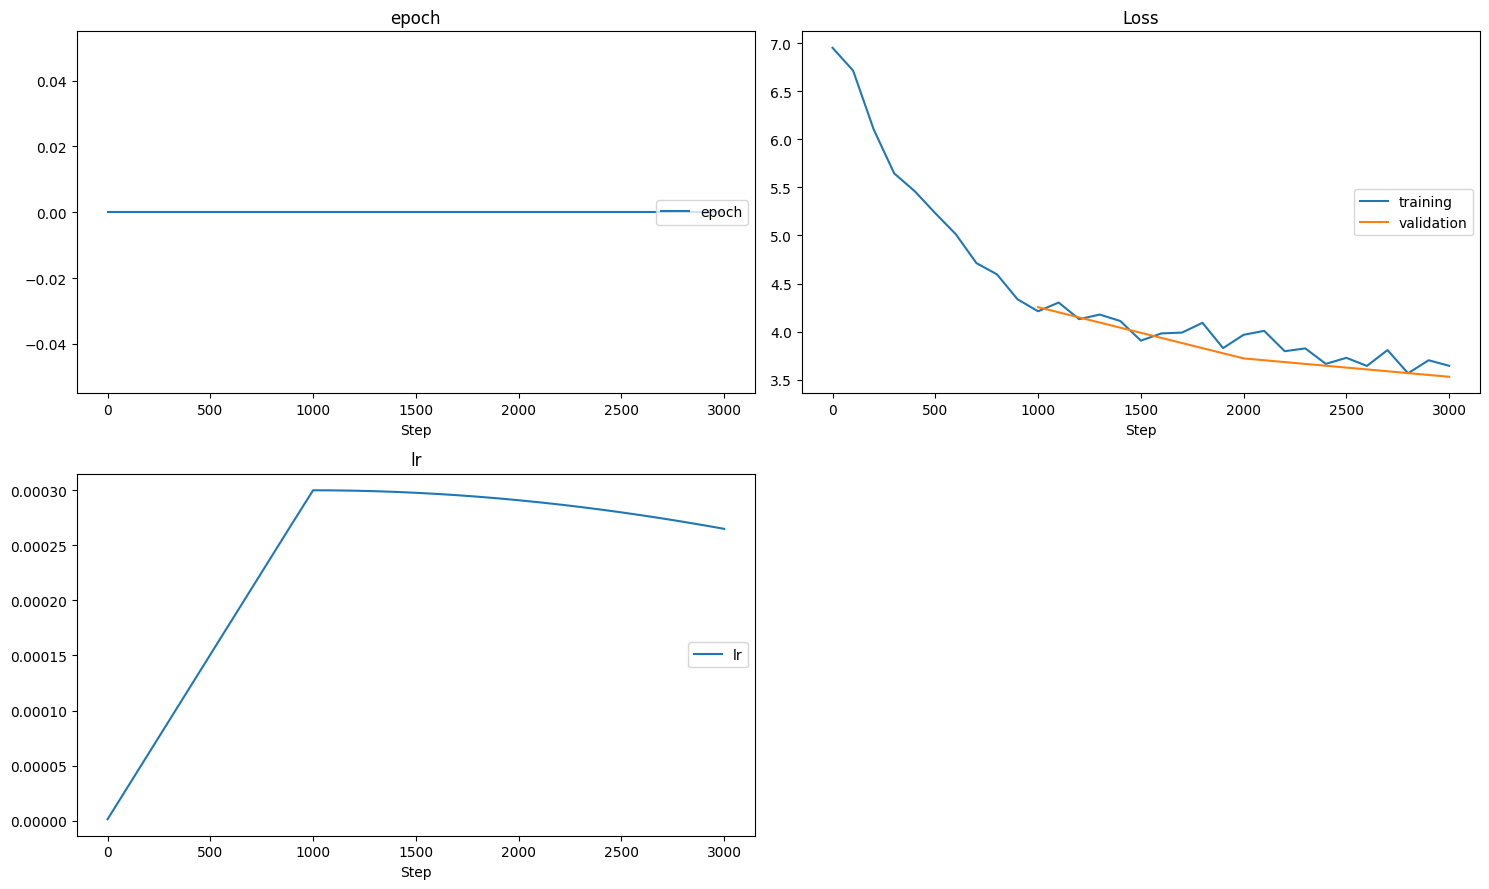

epoch
	epoch            	 (min:    0.000, max:    0.000, cur:    0.000)
Loss
	training         	 (min:    3.567, max:    6.951, cur:    3.645)
	validation       	 (min:    3.531, max:    4.254, cur:    3.531)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)


KeyboardInterrupt: 

In [65]:
# Обучение goes brrrr!

trainer.run(model, train_dataloader, test_dataloader)

In [ ]:
trainer.device

In [66]:
# Смотрим на качество генерации глазами
# Для маленьких и слабых моделей "затягиваем" гайки генерации

text = "Заходит в бар"
input_ids = torch.tensor(tokenizer.encode(text)[:-1], device=trainer.device)[None, :]
print(input_ids)
model_output = model.generate(
    input_ids, max_new_tokens=200, eos_token_id=tokenizer.eos_token_id, do_sample=True, top_k=10
)
tokenizer.decode(model_output[0].tolist())

tensor([[313, 259, 780, 262, 619, 820, 268]], device='mps:0')


'Заходит в бар, идет наслете. Сидин - некото не бывать, новает?  - Давай, а остоят:?  - А  - Ну, не воскре, как их ускать!  - А как-трок нет! А я, и говорит:  - Виду  - А что, тего покуда! Откром.  - Види, вчера написках, как устей  - Ну, второй  все 3%.  -  - Потому,   - Нет, уже поможе!  - Потому я рызно.   - Давай  - Он .  - Вдцали, как-то, след'

In [105]:
# Загружаем модель на хаб

model.push_to_hub(REPO_NAME)

model.safetensors:   0%|          | 0.00/30.1M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/andreykaa03/llm-course-hw1/commit/175d6a54a1002567db2adb4daee4e208260430b8', commit_message='Push model using huggingface_hub.', commit_description='', oid='175d6a54a1002567db2adb4daee4e208260430b8', pr_url=None, repo_url=RepoUrl('https://huggingface.co/andreykaa03/llm-course-hw1', endpoint='https://huggingface.co', repo_type='model', repo_id='andreykaa03/llm-course-hw1'), pr_revision=None, pr_num=None)

Поиграйтесь с гиперпараметрами, попробуйте обучить `mini` и `small` версии.
Постарайтесь добиться как можно более высокого качества как в терминах лосса, так и при визуальной оценке генерации.

### Дополнительные баллы

Вы также можно заработать дополнительные баллы:
- Реализовать Rotary Positional Embedding **[4 балла]**
- Реализовать Multi-Head Latent Attention **[2 балл]**
- Оформить репозиторий на 🤗: карточка модели с описанием задания, репортом качества и примерами генерации **[2 балл]**

# Специальный раздел для проверяющего

In [11]:
device = torch.device("mps")

tokenizer = ByteLevelBPETokenizer.from_pretrained(REPO_NAME)
check_model = TransformerForCausalLM.from_pretrained(REPO_NAME)
check_model = check_model.to(device)
check_model = check_model.eval()

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

Number of parameters: 79.51M


In [16]:
text = "Штирлиц пришел домой"
input_ids = torch.tensor(tokenizer.encode(text), device=device)
model_output = check_model.generate(
    input_ids[None, :-1], max_new_tokens=200, eos_token_id=tokenizer.eos_token_id, do_sample=True, top_k=10
)
tokenizer.decode(model_output[0].tolist())

'Штирлиц пришел домой и поезжает в Штататах. Из пенсионеров выходит мужик:- Я вас не вижу! Все сразу же, идите к нам.  [EOS]'